# Baseline model for batch monitoring example

In [10]:
import requests
import datetime
import pandas as pd

from evidently import DataDefinition
from evidently import Dataset
from evidently import Report
from evidently.metrics import ValueDrift, DriftedColumnsCount, MissingValueCount

from joblib import load, dump
from tqdm import tqdm

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

In [11]:
! mkdir data

In [12]:
files = [('green_tripdata_2024-03.parquet', './data')]

print("Download files:")
for file, path in files:
    url=f"https://d37ci6vzurychx.cloudfront.net/trip-data/{file}"
    resp=requests.get(url, stream=True)
    save_path=f"{path}/{file}"
    with open(save_path, "wb") as handle:
        for data in tqdm(resp.iter_content(),
                        desc=f"{file}",
                        postfix=f"save to {save_path}",
                        total=int(resp.headers["Content-Length"])):
            handle.write(data)

Download files:


green_tripdata_2024-03.parquet: 100%|█| 1372372/1372372 [00:02<00:00, 472818.11it/s, save to ./data/green_tripda


In [13]:
jan_data = pd.read_parquet('green_tripdata_2024-03.parquet')

In [14]:
jan_data.describe() # 57457

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
count,57457.000000,57457,57457,55360.000000,57457.000000,57457.000000,55360.000000,57457.000000,57457.000000,57457.000000,57457.000000,57457.000000,57457.000000,0.0,57457.000000,57457.000000,55360.000000,55353.000000,55360.000000
mean,1.877334,2024-03-16 04:02:52.405399,2024-03-16 04:21:00.076039,1.179986,95.524688,138.629149,1.309538,13.522828,17.313474,0.904472,0.577410,2.386255,0.192537,NaN,0.979378,22.904832,1.321062,1.038047,0.737730
min,1.000000,2008-12-31 23:02:24,2008-12-31 23:02:30,1.000000,1.000000,1.000000,0.000000,0.000000,-295.080000,-2.500000,-0.500000,-1.560000,0.000000,NaN,-1.000000,-296.080000,1.000000,1.000000,-2.750000
25%,2.000000,2024-03-08 13:53:56,2024-03-08 14:13:49,1.000000,74.000000,74.000000,1.000000,1.100000,9.300000,0.000000,0.500000,0.000000,0.000000,NaN,1.000000,13.440000,1.000000,1.000000,0.000000
50%,2.000000,2024-03-15 22:49:01,2024-03-15 23:09:52,1.000000,75.000000,138.000000,1.000000,1.790000,13.500000,0.000000,0.500000,2.000000,0.000000,NaN,1.000000,18.500000,1.000000,1.000000,0.000000
75%,2.000000,2024-03-23 20:11:25,2024-03-23 20:34:48,1.000000,97.000000,220.000000,1.000000,3.100000,19.800000,1.000000,0.500000,3.610000,0.000000,NaN,1.000000,27.050000,2.000000,1.000000,2.750000
max,2.000000,2024-04-01 00:01:45,2024-04-01 16:11:00,99.000000,265.000000,265.000000,9.000000,125112.200000,841.600000,10.000000,4.250000,150.000000,26.760000,NaN,1.000000,856.980000,5.000000,2.000000,2.750000
std,0.328056,NaN,NaN,1.356719,57.285088,76.295346,0.967749,770.416255,14.958249,1.382446,0.366916,3.159273,1.184551,NaN,0.154253,17.013735,0.497858,0.191311,1.218039


In [15]:
jan_data.shape

(57457, 20)

In [16]:
# create target
jan_data["duration_min"] = jan_data.lpep_dropoff_datetime - jan_data.lpep_pickup_datetime
jan_data.duration_min = jan_data.duration_min.apply(lambda td : float(td.total_seconds())/60)

In [17]:
# filter out outliers
jan_data = jan_data[(jan_data.duration_min >= 0) & (jan_data.duration_min <= 60)]
jan_data = jan_data[(jan_data.passenger_count > 0) & (jan_data.passenger_count <= 8)]

<Axes: >

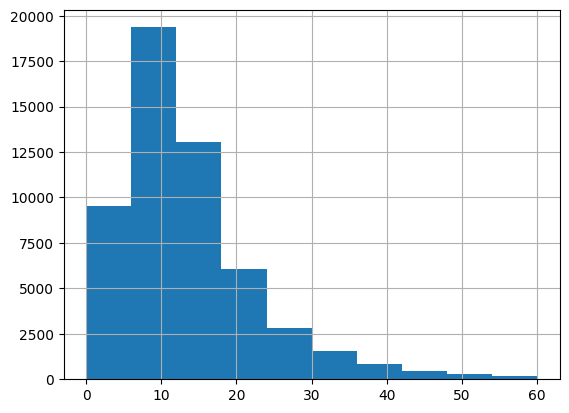

In [18]:
jan_data.duration_min.hist()

In [19]:
# data labeling
target = "duration_min"
num_features = ["passenger_count", "trip_distance", "fare_amount", "total_amount"]
cat_features = ["PULocationID", "DOLocationID"]

In [20]:
jan_data.shape

(54135, 21)

In [21]:
train_data = jan_data[:30000]
val_data = jan_data[30000:]

In [22]:
model = LinearRegression()

In [23]:
model.fit(train_data[num_features + cat_features], train_data[target])

LinearRegression()

In [24]:
train_preds = model.predict(train_data[num_features + cat_features])
train_data['prediction'] = train_preds

In [25]:
val_preds = model.predict(val_data[num_features + cat_features])
val_data['prediction'] = val_preds

In [26]:
print(mean_absolute_error(train_data.duration_min, train_data.prediction))
print(mean_absolute_error(val_data.duration_min, val_data.prediction))

3.7724732393594484
3.71681456792937


# Dump model and reference data

In [27]:
! mkdir models

In [28]:
with open('models/lin_reg.bin', 'wb') as f_out:
    dump(model, f_out)

In [29]:
val_data.to_parquet('data/reference.parquet')

# Evidently Report

In [ ]:
data_definition = DataDefinition(numerical_columns=num_features + ['prediction'], categorical_columns=cat_features)
train_dataset = Dataset.from_pandas(
    train_data,
    data_definition
)

val_dataset = Dataset.from_pandas(
    val_data,
    data_definition
)

In [ ]:
report = Report(metrics=[
    ValueDrift(column='prediction'),
    DriftedColumnsCount(),
    MissingValueCount(column='prediction'),
]
)

In [ ]:
snapshot = report.run(reference_data=train_dataset, current_data=val_dataset)

In [ ]:
snapshot

In [ ]:
result = snapshot.dict()

In [ ]:
result

In [ ]:
#prediction drift
result['metrics'][0]['value']

In [ ]:
#number of drifted columns
result['metrics'][1]['value']['count']

In [ ]:
#share of missing values
result['metrics'][2]['value']['count']

# Evidently Dashboard

In [ ]:
from evidently.presets import DataDriftPreset, DataSummaryPreset

from evidently.ui.workspace import Workspace
from evidently.sdk.panels import *
from evidently.legacy.renderers.html_widgets import WidgetSize

In [ ]:
ws = Workspace("workspace")

In [ ]:
project = ws.create_project("NYC Taxi Data Quality Project")
project.description = "My project description"
project.save()

In [ ]:
regular_report = Report(
    metrics=[
        DataSummaryPreset()
    ],
)

data = Dataset.from_pandas(
    val_data.loc[val_data.lpep_pickup_datetime.between('2022-01-28', '2022-01-29', inclusive="left")],
    data_definition=data_definition,
)

regular_snapshot = regular_report.run(current_data=data, timestamp=datetime.datetime(2022,1,28))

regular_snapshot

In [ ]:
ws.add_run(project.id, regular_snapshot)

note: To view a report please run "evidently ui" command in a separate tab in your terminal.

In [ ]:
#configure the dashboard
project.dashboard.add_panel(
    text_panel(title="NYC taxi data dashboard")
)

project.dashboard.add_panel(
    bar_plot_panel(
        title="Inference Count",
        values=[
            PanelMetric(
                metric="RowCount",
                legend="count",
            ),
        ],
        size="half",
    ),
)

project.dashboard.add_panel(
    line_plot_panel(
        title="Number of Missing Values",
        values=[
            PanelMetric(
                metric="DatasetMissingValueCount",
                legend="count"
            ),
        ],
        size="half",
    ),
)

project.save()

To view a dashboard please run "evidently ui" command in a separate tab in your terminal.

In [ ]:
regular_report = Report(
    metrics=[
        DataSummaryPreset()
    ],
)

data = Dataset.from_pandas(
    val_data.loc[val_data.lpep_pickup_datetime.between('2022-01-29', '2022-01-30', inclusive="left")],
    data_definition=data_definition,
)

regular_run = regular_report.run(current_data=data, timestamp=datetime.datetime(2022,1,29))

regular_run

In [ ]:
ws.add_run(project.id, regular_run)